In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re


## Finetune DistilledBert 

In [56]:
user_df = pd.read_csv('data/user_concat_text_10_20.csv',sep=';')
user_df.head()

,user_id,text
0,1.000018e+20,Great food. The service was a little slow. It ...
1,1.000020e+20,I like the variety of burgers they offer. But ...
2,1.000027e+20,Margarita was yummy. Food not great.\nCrazy No...
3,1.000030e+20,Very good food a little pricey but worth every...
4,1.000057e+20,Delightful and charming place to dine outside....


In [57]:
cleaned_df = pd.read_csv('data/cleaned_df.csv')
cleaned_df = cleaned_df.dropna()
cleaned_df = cleaned_df[~cleaned_df['price'].isin(['₩₩', '₩', '₩₩₩₩', '₩₩₩'])]
cleaned_df  = cleaned_df[['user_id','gmap_id', 'text', 'rating' ]]
clenead_df


,user_id,gmap_id,text,rating
0,1.117182e+20,0x89e3f6144d96a7f1:0x78577cee81076e28,Excellent breakfast. Very good coffee. Homemad...,5
1,1.105225e+20,0x89e3f6144d96a7f1:0x78577cee81076e28,Great neighborhood diner. Great food. Wonderfu...,5
2,1.091366e+20,0x89e3f6144d96a7f1:0x78577cee81076e28,Fantastic food has great prices. Great atmosph...,5
3,1.045746e+20,0x89e3f6144d96a7f1:0x78577cee81076e28,Old fashion Dinner. Love this place,5
4,1.075780e+20,0x89e3f6144d96a7f1:0x78577cee81076e28,Bland food. Although the employees were really...,2
...,...,...,...,...
55372,1.124470e+20,0x89e3a43f66fccc79:0x4058e86c35f55c61,Great food and beer selection. Has a very diff...,5
55373,1.169013e+20,0x89e3a43f66fccc79:0x4058e86c35f55c61,I ate here with my two sons and their grandpar...,5
55374,1.090290e+20,0x89e3a43f66fccc79:0x4058e86c35f55c61,Great atmosphere and very good food. The pizza...,4
55375,1.138475e+20,0x89e3a43f66fccc79:0x4058e86c35f55c61,"Love this place. Food is always great, pizza i...",5


We will fine-tune distilled_bert through the text classification task: we will let model classify the review text into 5 categories representing ratings (between 1 through 5).

In [38]:
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer
import tensorflow as tf

from transformers import TFDistilBertForSequenceClassification


# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    cleaned_df['text'], cleaned_df['rating'], test_size=0.2, random_state=42
)

# Adjust labels to be zero-indexed
train_labels = train_labels - 1
val_labels = val_labels - 1

# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def encode_texts(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")

# Tokenize data
train_encodings = encode_texts(train_texts)
val_encodings = encode_texts(val_texts)
# Convert labels to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']},
    train_labels
)).shuffle(len(train_texts)).batch(128)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']},
    val_labels
)).batch(128)


# Load the pre-trained DistilBERT model
model2 = TFDistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', 
    num_labels=len(set(cleaned_df['rating']))  # Set the number of labels to the number of unique ratings
)

# Compile the model
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model2.summary()



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
 dropout_199 (Dropout)       multiple                  0 (unused)
                                                                 
Total params: 66957317 (255.42 MB)
Trainable params: 66957317 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

history2 = model2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=9,
    callbacks=[early_stopping_callback]
)


Epoch 1/9
347/347 [==============================] - 534s 1s/step - loss: 0.8694 - accuracy: 0.6247 - val_loss: 0.7832 - val_accuracy: 0.6626
Epoch 2/9
347/347 [==============================] - 512s 1s/step - loss: 0.7347 - accuracy: 0.6797 - val_loss: 0.7858 - val_accuracy: 0.6629
Epoch 3/9
347/347 [==============================] - 511s 1s/step - loss: 0.6402 - accuracy: 0.7249 - val_loss: 0.8144 - val_accuracy: 0.6580
Epoch 4/9
347/347 [==============================] - 512s 1s/step - loss: 0.5394 - accuracy: 0.7768 - val_loss: 0.8747 - val_accuracy: 0.6541
Epoch 5/9
347/347 [==============================] - 512s 1s/step - loss: 0.4264 - accuracy: 0.8291 - val_loss: 1.0195 - val_accuracy: 0.6486
Epoch 5: early stopping


In [40]:
model2.save('saved_models/distilled_model1')

INFO:tensorflow:Assets written to: saved_models/distilled_model1/assets


INFO:tensorflow:Assets written to: saved_models/distilled_model1/assets


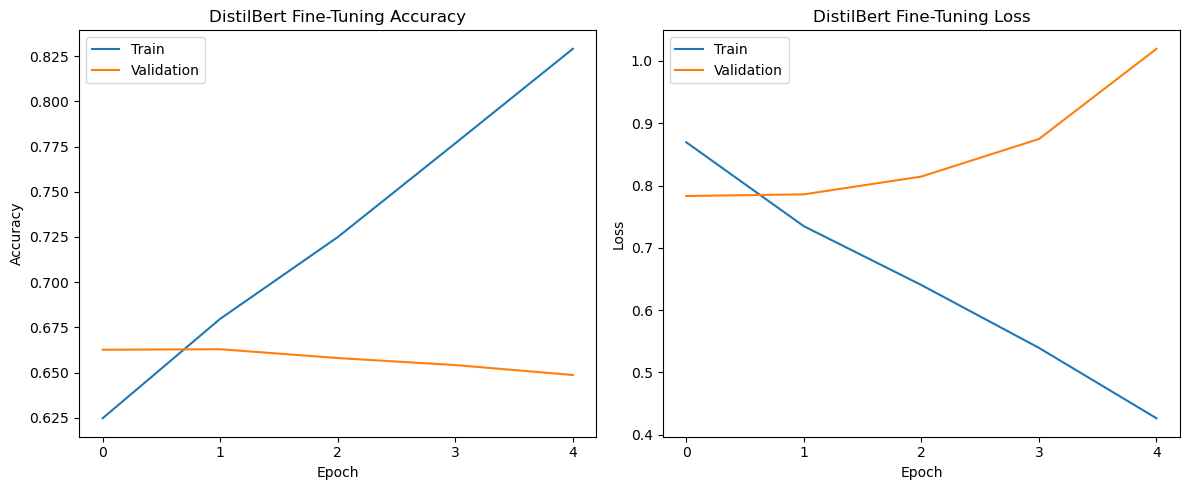

In [43]:


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('DistilBert Fine-Tuning Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.xticks([0, 1, 2, 3, 4])  # Set x-axis ticks to start at 1

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('DistilBert Fine-Tuning Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.xticks([0, 1, 2, 3, 4])  # Set x-axis ticks to start at 1

plt.tight_layout()
plt.show()


## Get Embeddings Using Fine-Tuned Distilled Bert Weights

In [50]:
def encode_texts(texts):
    # Ensure the texts parameter is treated as a list directly
    return tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="tf")

from transformers import TFDistilBertModel

# Load the base model
model_base = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=model2.config)

# Manually transfer weights from the fine-tuned classification model to the base model
model_base.set_weights(model2.distilbert.get_weights())

# Now use this model to extract embeddings
def get_embeddings(text):
    encodings = encode_texts([text])
    outputs = model_base(encodings['input_ids'], attention_mask=encodings['attention_mask'])
    # Using the last hidden state
    hidden_states = outputs.last_hidden_state[:, 0, :].numpy()  # CLS token output
    return hidden_states

user_df['text_embedding'] = user_df['text'].apply(get_embeddings)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [51]:
user_df.head()

,user_id,text,text_embedding
0,1.000018e+20,Great food. The service was a little slow. It ...,"[[-0.09031649, -0.87733984, -0.8550365, 1.0098..."
1,1.000020e+20,I like the variety of burgers they offer. But ...,"[[0.12926187, -0.89539665, -0.19191237, 0.8793..."
2,1.000027e+20,Margarita was yummy. Food not great.\nCrazy No...,"[[0.012265073, -0.6484629, -0.006106712, 1.210..."
3,1.000030e+20,Very good food a little pricey but worth every...,"[[0.26658517, -0.34426978, -0.49511626, 0.8546..."
4,1.000057e+20,Delightful and charming place to dine outside....,"[[0.4648932, -0.8820121, 0.44756183, 0.5655584..."


In [52]:
user_df.to_csv("data/user_reviews_distillbert_df.csv", index=False)